# Show, Attend and Tell

Alumno: Phabel Antonio López Delgado

Redes Neuronales para Secuencias

In [ ]:
!pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1

In [ ]:
!pip install torchtext

In [ ]:
import os
import numpy as np
from typing import List, Dict, Tuple
from collections import defaultdict, Counter

import torch
import torchtext
import torchtext.vocab
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split

import torchvision.transforms as transforms

/usr/local/lib/python3.12/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


# 1. Introducción

Bienvenidos al cuaderno de Jupyter sobre su proyecto para el módulo 12 del curso, en este, nos enfocaremos en replicar el modelo utilizado en el artículo "Show, Attend and Tell: Neural Image Caption Generation with Visual Attention". Este artículo revolucionó la generación de descripciones para imágenes al introducir un mecanismo de atención que le permite al modelo enfocarse en diferentes partes de la imagen mientras genera una descripción de esta, para esto, en lugar de simplemente procesar la imagen completa y generar una descripción, el modelo tiene la capacidad de poner atención en diferentes regiones de la imagen, lo que le permite generar descripciones más precisas y detalladas. Te recomiendo leer el artículo antes de continuar con el proyecto, lo puedes encontrar [aquí](http://proceedings.mlr.press/v37/xuc15.pdf).

La idea centras detrás del mecanismo de atención es que, en lugar de codificar toda la imagen en un solo vector de características y usarlo para generar una descripción, el modelo genera un conjunto de vectores de anotaciones "annotation vectors" para diferentes regiones de la imagen. Posteriormente, mientras se genera la descripción palabra por palabra y utilizando estos vectores de anotaciones, el modelo decide a que regiones de la imagen "atender".

En este cuaderno, diseñarás los elementos que componen a este modelo en PyTorch, procesarás y contruiras los conjuntos de entrenamiento usados, generarás el ciclo de entrenamiento del modelo y generarás descripciones de imágenes con este. El cuaderno contiene una definición base de código de todas estas secciones; sin embargo, es tu trabajo completarlas y pasar las pruebas unitarias asociadas para verificar que tu código funciona correctamente.


## Índice de Contenidos
1. Definición del Modelo en PyTorch
    - Encoder: Extracción de vectores de anotación.
    - Attention: Generación del vector de contexto.
    - LSTM: Implementación personalizada de la celda LSTM.
    - Decoder: Generación de palabras utilizando la celda LSTM.
    - SequenceToSequnce: Orquestación del proceso de generación de descripciones.
2. Creación de Datasets y Dataloaders
    - Lectura y procesamiento de descripciones de imágenes.
    - Generación del vocabulario.
    - Definición del Dataset "Flickr8kDataset".
    - División de conjuntos de datos y definición de dataloaders.
3. Fase de Entrenamiento
    - Definición de modelos, optimizadores y funciones de pérdida.
    - Configuración de metaparámetros del entrenamiento.
    - Función de entrenamiento y seguimiento del progreso.
4. Análisis de Resutados, Generación de Descripciones.
    - Visualización de descripciones generadas por el modelo.

Espero que este cuaderno les brinde una comprensión clara y práctica del mecanismo de atención y cómo se puede utilizar para mejorar la generación de descripciones de imágenes. ¡Suerte!

## Detalles del Modelo
### Módulo Encoder
El encoder actúa como la primera etapa en nuestro proceso de generación de descripciones y juega un papel crucial en la extracción de información relevante de las imágenes. En lugar de simplemente convertir toda la imagen en un único vector de características, el encoder utilizado aquí se basa en la arquitectura vgg16, una red neuronal convolucional profunda y ampliamente reconocida por su eficacia en tareas de visión por computadora. El objetivo principal del encoder es producir lo que llamamos "vectores de anotaciones". Estos vectores representan diferentes regiones de la imagen y capturan la esencia de lo que está presente en esas regiones. En términos prácticos, tomamos los feature maps de la última capa convolucional de vgg16 antes de aplicar max pooling. Estos feature maps, originalmente de dimensiones (14, 14, 512), se transforman para que tengan dimensiones (196, 512), lo que nos indica que tenemos $L=196$ distintos vectores de anotaciones para cada imagen, cada uno con $D=512$ valores. Este conjunto de vectores que denominaremos con la letra $a$ serán la base sobre la cual el mecanismo de atención decidirá a qué partes de la imagen "atender" mientras genera la descripción.

$$a = \left\{ \boldsymbol{a_1}, ..., \boldsymbol{a_L}\right\}, \;\;\boldsymbol{a_i} \in \mathbb{R}^D$$
## Módulo de Atención
El módulo de atención es una pieza central en nuestro modelo de generación de descripciones y es el responsable de decidir a qué partes específicas de la imagen debe "atender" el modelo en cada paso de la generación de la descripción. La idea es que, en lugar de usar toda la información de la imagen en cada paso, el modelo pondera diferentes regiones de la imagen basándose en su relevancia para la palabra que está generando.

Para lograr esto, el módulo de atención toma como entrada el estado oculto anterior del decodificador $\boldsymbol{s_{i-1}}$ y los vectores de anotaciones $a$ y los injecta en una red neuronal (que es entrenada con el resto del modelo) para calcular "puntuaciones de atención" $e_{ij}$ para cada vector de anotación. Estas puntuaciones indican que tan relevante es cada parte de la imagen para la generación de la siguiente palabra de la descripción de la imagen.

A continuación, estas puntuaciones de atención $e_{ij}$ se pasan por una función softmax para obtener los pesos de atención "alpha" $\alpha_{ij}$. La función softmax asegura que estos pesos estén en el rango $[0,1]$ y que su suma sea $1$, lo que permite que actúen como probabilidades que indican la importancia de cada vector de anotación en relación con los demás.

Una vez calculadas las puntuaciones, se aplican a los vectores de anotación para producir un "vector de contexto" $\boldsymbol{z_i}$. Este vector de contexto es una combinación ponderada de los vectores de anotación y captura las partes más relevantes de la imagen para el paso actual de generación de palabras. Es este vector de contexto el que se pasa al decodificador para influir en la generación de la siguiente palabra.

$$\boldsymbol{z_i} = \sum_{j=1}^{T_x} \alpha_{ij}\boldsymbol{h_j}$$

### Módulo LSTM
En nuestro modelo de generación de descripciones, utilizamos una variante especial de la celda LSTM definida en el artíclo. A diferencia de las celdas LSTM tradicionales, esta versión incorpora el vector de contexto, que proviene del módulo de atención y representa las regiones relevantes de la imagen. Esta integración del vector de contexto en la celda LSTM asegura que la información visual relevante se tenga en cuenta en cada paso de la generación de la descripción. Específicamente, el vector de contexto se inyecta en las compuertas de la LSTM, influenciando las decisiones sobre qué información retener, actualizar o ignorar en el estado de celda y el estado oculto. Las ecuaciones de la celda LSTM son las siguientes:

\begin{align*}
\boldsymbol{i_t} &= \sigma(\boldsymbol{W_i} \boldsymbol{E_{y_{t-1}}} + \boldsymbol{U_i}\boldsymbol{h_{t-1}} + \boldsymbol{Z_i}\boldsymbol{z_i} + \boldsymbol{b_i})\\
\boldsymbol{f_t} &= \sigma(\boldsymbol{W_f} \boldsymbol{E_{y_{t-1}}} + \boldsymbol{U_f}\boldsymbol{h_{t-1}} + \boldsymbol{Z_f}\boldsymbol{z_i} + \boldsymbol{b_f})\\
\boldsymbol{c_t} &= \boldsymbol{f_t}\boldsymbol{c_{t-1}} + \boldsymbol{i_t}tanh\left( \boldsymbol{W_c} \boldsymbol{E_{y_{t-1}}} + \boldsymbol{U_c}\boldsymbol{h_{t-1}} + \boldsymbol{Z_c}\boldsymbol{z_i} + \boldsymbol{b_c} \right)\\
\boldsymbol{o_t} &= \sigma(\boldsymbol{W_o} \boldsymbol{E_{y_{t-1}}} + \boldsymbol{U_o}\boldsymbol{h_{t-1}} + \boldsymbol{Z_o}\boldsymbol{z_i} + \boldsymbol{b_o})\\
\boldsymbol{h_t} &= \boldsymbol{o_t}tanh(\boldsymbol{c_t})
\end{align*}


### Módulo Decoder
El módulo Decoder es el encargado de traducir los vectores de características de la imagen, junto con el contexto proporcionado por el módulo de atención, en una secuencia de palabras que forman la descripción de la imagen. Funciona en pasos, generando una palabra en cada iteración hasta completar la descripción.

El proceso comienza con la codificación en embeddings de la palabra anteriormente generada (o la palabra inicial en el primer paso). Esta codificación convierte la palabra en un vector que puede ser procesado por la red. A continuación, este vector, junto con el vector de contexto y los estados oculto y de celda anteriores, se pasan a través de nuestra celda LSTM especializada. Una vez que se obtiene el nuevo estado oculto de la LSTM, este se pasa a través de una capa lineal para obtener los "logits" para cada palabra en el vocabulario. Estos "logits" representan las puntaciones de cada palabra de ser la siguiente en la descripción. La palabra con el valor más alto se selecciona como la siguiente palabra en la secuencia.

### Módulo SequenceToSequence
El módulo SequenceToSequence es el corazón del proceso de generación de descripciones y actúa como un orquestador que une todos los componentes principales del modelo: el Encoder, el módulo de Atención y el Decoder.

Codificación de la Imagen: Primero, las imágenes se pasan a través del Encoder, que extrae características visuales relevantes de la imagen. Estas características, también conocidas como vectores danotacionesón, actúan como una representación comprimida de la imagen y capturan la información esencial necesaria para generar una descripción.

Iniciación de la Decodificación: Antes de comenzar el proceso de decodificación, se inicializan los estados oculto y de celda del Decoder con ceros. Además, se establece la primera palabra de la secuencia de salida como el token <SOS> (Start of Sequence), indicando el comienzo de una nueva descripción.

Decodificación Paso a Paso: A continuación, en cada paso temporal, el modelo utiliza el estado oculto actual y los vectoranotacionestación para calcular un vector de contexto utilizando el módulo de Atención. Este vector de contexto, que es una representación ponderada de las características visuales, se combinlos embeddingstación de la palabra actual y se pasa al Decoder. El Decoder genera logits para la siguiente palabra en la descripción. Durante el entrenamiento, se utiliza la técnica de "teacher forcing", lo que significa que la palabra real del conjunto de datos se utiliza como entrada para el siguiente paso, en lugar de la palabra predicha en el paso anterior.

Salida: El proceso de decodificación continúa hasta que se ha generado una secuencia completa de palabras. La salida final es un tensor que contiene logits para cada palabra en el vocabulario, en cada paso temporal.

# 2. Definición del Modelo

En esta sección, implementarás los cuatro módulos esenciales para el modelo: Encoder, Attention, LSTM y SequenceToSequence. Para todos, utiliza las siguientes instrucciones:

- Completar el Código: En cada módulo, encontrarán secciones marcadas con "TODO". Tu tarea es completar estas secciones con el código necesario para que este funcione correctamente según las especificaciones y la lógica descrita.

- Pruebas Unitarias: Después de completar las secciones "TODO" en cada módulo, ejecuta las prueba unitarias correspondiente para ese módulo. Estas pruebas están diseñadas para ayudarles a verificar si su implementación es correcta. Es esencial que no modifiquen estas pruebas; si lo hacen, es posible que no les sirvan como guía adecuada.

- Revisión del Código: Tengan en cuenta que, aunque las pruebas unitarias son una herramienta útil, pasar estas pruebas no garantiza una calificación completa. Su código será revisado detalladamente para asegurarse de que cumple con todas las especificaciones y que está correctamente implementado. Las pruebas están ahí para servir como una guía inicial, pero no son exhaustivas.

Finalmente, recuerden revisar y probar su código cuidadosamente antes de enviarlo. Asegúrense de entender cada parte del código que escriben y cómo contribuye al funcionamiento general del modelo.

¡Buena suerte y a programar!

## 2.1 Módulo Encoder

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # TODO: Importa el modelo vgg16 utilizando torchvision, carga los pesos por defecto.
        vgg16 = torchvision.models.vgg16(pretrained=True)

        # TODO: Elimina la última capa de max pooling para obtener el mapa de características de 14x14x512.
        self.features = torch.nn.Sequential(*list(vgg16.features.children())[:-1])

        # TODO: Congela las capas del modelo para evitar actualizar los pesos durante el entrenamiento.
        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        # x: [batch_size, 3, 224, 224]
        # TODO: Pasar la entrada a través de las capas de características de VGG16. La salida debe de tener
        # dimensiones [batch_size, 512, 14, 14]
        x = self.features(x)

        # Se redimensiona el x a [batch_size, 512, 196].
        x = x.permute(0, 2, 3, 1)  # [batch_size, 14, 14, 512]
        x = x.view(x.size(0), -1, x.size(3))  # [batch_size, 196, 512]

        return x

In [ ]:
def test_encoder():
    # Crear un tensor aleatorio con forma [batch_size, 3, 224, 224]
    input_tensor = torch.rand((8, 3, 224, 224))

    # Inicializar el encoder
    encoder = Encoder()

    # Pasar el tensor a través del encoder
    output = encoder(input_tensor)

    # Prueba 1: Verificar las dimensiones de salida
    assert output.shape == (8, 196, 512), f"Se esperaba una forma de salida (8, 196, 512), pero se obtuvo {output.shape}"

    # Prueba 2: Verificar si las capas de VGG16 están congeladas
    for param in encoder.features.parameters():
        assert not param.requires_grad, "¡Algunas capas de VGG16 no están congeladas!"

    print("¡Todas las pruebas pasaron con éxito!")

test_encoder()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


¡Todas las pruebas pasaron con éxito!


## 2.2 Módulo de Atención

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super().__init__()

        # Capas lineales necesarias para calcular las puntuaciones de atención
        self.U_a = torch.nn.Linear(encoder_dim, attention_dim)  # [encoder_dim, attention_dim]
        self.W_a = torch.nn.Linear(decoder_dim, attention_dim)  # [decoder_dim, attention_dim]
        self.v_a = torch.nn.Linear(attention_dim, 1)            # [attention_dim, 1]

    def forward(self, h, encoder_out):
        """
        h: previous hidden state of the decoder, shape: [batch_size, decoder_dim]
        encoder_out: output of the encoder, shape: [batch_size, L, encoder_dim]
        """
        # TODO: Aplica la capa lineal a los vectores de anotaciones. El resultado se espera que tenga las
        # siguientes dimensiones [batch_size, L, attention_dim]
        u_hs = self.U_a(encoder_out)

        # TODO: Procesa el estado oculto del decodificador con su capa lineal y expande sus dimensiones para
        # que coincida (en número de dimensiones) con la del resultado anterior.
        w_ah = self.W_a(h)                    # [batch_size, attention_dim]
        w_ah = w_ah.unsqueeze(1)              # [batch_size, 1, attention_dim]

        # Se calculan las puntuaciones de atención.
        # F.tanh(u_hs + w_ah): [batch_size, L, attention_dim]
        attn_scores = self.v_a(torch.nn.functional.tanh(u_hs + w_ah))  # [batch_size, L, 1]
        attn_scores = attn_scores.squeeze(2)  # [batch_size, L]

        # TODO: Calcula los pesos de atención usando softmax sobre attn_scores.
        alpha = torch.nn.functional.softmax(attn_scores, dim=1)  # [batch_size, L]

        # Se calcula el vector de contexto como la suma ponderada de las salidas del encoder.
        context_vector = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # [batch_size, encoder_dim]

        return context_vector, alpha

In [ ]:
def test_attention_module():
    # Parámetros de prueba
    batch_size = 8
    encoder_dim = 512
    decoder_dim = 256
    attention_dim = 128

    # Crear tensores aleatorios para la salida del encoder y el estado oculto del decodificador
    encoder_out = torch.rand((batch_size, 196, encoder_dim))
    h = torch.rand((batch_size, decoder_dim))

    # Inicializar el módulo de atención
    attention = Attention(encoder_dim, decoder_dim, attention_dim)

    # Obtener el vector de contexto y los pesos de atención
    context_vector, alpha = attention(h, encoder_out)

    # Prueba 1: Verificar las dimensiones de salida
    assert context_vector.shape == (batch_size, encoder_dim), f"Se esperaba una forma de salida (batch_size, encoder_dim), pero se obtuvo {context_vector.shape}"
    assert alpha.shape == (batch_size, 196), f"Se esperaba una forma de salida (batch_size, 196) para los pesos de atención, pero se obtuvo {alpha.shape}"

    # Prueba 2: Verificar que la suma de los pesos de atención sea 1
    assert torch.allclose(alpha.sum(dim=1), torch.tensor([1.0] * batch_size), atol=1e-5), "La suma de los pesos de atención no es 1 para todos los ejemplos en el batch."

    print("¡Todas las pruebas pasaron con éxito!")

test_attention_module()

¡Todas las pruebas pasaron con éxito!


## 2.2 Módulo Celda LSTM

In [ ]:
class LSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, context_size):
        super().__init__()

        # Se definen los parámetros para la compuerta de entrada (input gate).
        self.W_i = torch.nn.Parameter(torch.randn(input_size, hidden_size))
        self.U_i = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.Z_i = torch.nn.Parameter(torch.randn(context_size, hidden_size))
        self.b_i = torch.nn.Parameter(torch.randn(hidden_size))

        # TODO: Define los parámetros para la compuerta de olvido (Forget gate).
        self.W_f = torch.nn.Parameter(torch.randn(input_size, hidden_size))
        self.U_f = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.Z_f = torch.nn.Parameter(torch.randn(context_size, hidden_size))
        self.b_f = torch.nn.Parameter(torch.randn(hidden_size))

        # TODO: Define los parámetros para la compuerta de celda (Cell gate).
        self.W_c = torch.nn.Parameter(torch.randn(input_size, hidden_size))
        self.U_c = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.Z_c = torch.nn.Parameter(torch.randn(context_size, hidden_size))
        self.b_c = torch.nn.Parameter(torch.randn(hidden_size))

        # TODO: Define los parámetros para la compuerta de salida (Output gate).
        self.W_o = torch.nn.Parameter(torch.randn(input_size, hidden_size))
        self.U_o = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.Z_o = torch.nn.Parameter(torch.randn(context_size, hidden_size))
        self.b_o = torch.nn.Parameter(torch.randn(hidden_size))

    def forward(self, x, hc, context):
        h, c = hc

        # Se calcula la activación de la compuerta de entrada.
        i = torch.sigmoid(x @ self.W_i + h @ self.U_i + context @ self.Z_i + self.b_i)

        # TODO: Calcula la activación de la compuerta de olvido
        f = torch.sigmoid(x @ self.W_f + h @ self.U_f + context @ self.Z_f + self.b_f)

        # Se calcula candidato de activación para la compuerta de celda.
        c_tilde = torch.tanh(x @ self.W_c + h @ self.U_c + context @ self.Z_c + self.b_c)

        # TODO: Calcula la activación de la compuerta de salida
        o = torch.sigmoid(x @ self.W_o + h @ self.U_o + context @ self.Z_o + self.b_o)

        # TODO: Actualiza el estado de celda usando las activaciones anteriores
        c = f * c + i * c_tilde

        # TODO: Calcula el nuevo estado oculto
        h = o * torch.tanh(c)

        return h, c  # [batch_size, hidden_dim], [batch_size, hidden_dim]

In [ ]:
def test_lstm_module():
    # Parámetros de prueba
    batch_size = 8
    input_size = 256
    hidden_size = 512
    context_size = 512

    # Crear tensores aleatorios para la entrada, estado oculto, estado de celda y vector de contexto
    x = torch.rand((batch_size, input_size))
    h = torch.rand((batch_size, hidden_size))
    c = torch.rand((batch_size, hidden_size))
    context = torch.rand((batch_size, context_size))

    # Inicializar el módulo LSTM
    lstm = LSTM(input_size, hidden_size, context_size)

    # Obtener el estado oculto y estado de celda actualizados
    h_new, c_new = lstm(x, (h, c), context)

    # Prueba 1: Verificar las dimensiones de salida
    assert h_new.shape == (batch_size, hidden_size), f"Se esperaba una forma de salida (batch_size, hidden_size) para h, pero se obtuvo {h_new.shape}"
    assert c_new.shape == (batch_size, hidden_size), f"Se esperaba una forma de salida (batch_size, hidden_size) para c, pero se obtuvo {c_new.shape}"

    # Prueba 2: Verificar que los valores de salida no sean iguales a los de entrada (se ha realizado alguna actualización)
    assert not torch.equal(h, h_new), "El estado oculto no se actualizó."
    assert not torch.equal(c, c_new), "El estado de celda no se actualizó."

    print("¡Todas las pruebas pasaron con éxito!")

test_lstm_module()

¡Todas las pruebas pasaron con éxito!


## 2.3 Módulo Decoder

In [ ]:
class Decoder(torch.nn.Module):
    def __init__(self, embed_dim, decoder_dim, vocab_size, encoder_dim):
        super().__init__()

        # TODO: Define la capa embedding para las palabras.
        self.embedding = torch.nn.Embedding(vocab_size, embed_dim)

        # TODO: Inicializa la celda LSTM especializada.
        self.lstm = LSTM(embed_dim, decoder_dim, encoder_dim)

        self.fc = torch.nn.Linear(decoder_dim, vocab_size)

    def forward(self, context_vector, h, c, embeddings):
        """Decode image feature vectors and generates captions.
        :param context_vector: attention-weighted encoding, a tensor of dimension (batch_size, encoder_dim)
        :param h: previous hidden state, a tensor of dimension (batch_size, decoder_dim)
        :param c: previous cell state, a tensor of dimension (batch_size, decoder_dim)
        :param embeddings: embedded word of the previous step, a tensor of dimension (batch_size, embed_dim)
        :return: predictions for next word, hidden state, cell state
        """
        # TODO: Pasa los embeddings y el vector de contexto a través de la celda LSTM.
        hidden, cell = self.lstm(embeddings, (h, c), context_vector)
        # hidden: [batch_size, hidden_dim]
        # cell: [batch_size, hidden_dim]

        # TODO: Transforma el estado oculto en "logits" para cada palabra del vocabulario
        logits = self.fc(hidden)
        # logits: [batch_size, vocab_size]

        return logits, hidden, cell

In [ ]:
def test_decoder_module():
    # Parámetros de prueba
    batch_size = 8
    embed_dim = 256
    decoder_dim = 512
    vocab_size = 1000
    encoder_dim = 512

    # Crear tensores aleatorios para el vector de contexto, estado oculto, estado de celda y embeddings
    context_vector = torch.rand((batch_size, encoder_dim))
    h = torch.rand((batch_size, decoder_dim))
    c = torch.rand((batch_size, decoder_dim))
    embeddings = torch.rand((batch_size, embed_dim))

    # Inicializar el módulo Decoder
    decoder = Decoder(embed_dim, decoder_dim, vocab_size, encoder_dim)

    # Obtener los logits, estado oculto y estado de celda actualizados
    logits, h_new, c_new = decoder(context_vector, h, c, embeddings)

    # Prueba 1: Verificar las dimensiones de salida
    assert logits.shape == (batch_size, vocab_size), f"Se esperaba una forma de salida (batch_size, vocab_size) para logits, pero se obtuvo {logits.shape}"
    assert h_new.shape == (batch_size, decoder_dim), f"Se esperaba una forma de salida (batch_size, decoder_dim) para h, pero se obtuvo {h_new.shape}"
    assert c_new.shape == (batch_size, decoder_dim), f"Se esperaba una forma de salida (batch_size, decoder_dim) para c, pero se obtuvo {c_new.shape}"

    # Prueba 2: Verificar que los valores de salida no sean iguales a los de entrada (se ha realizado alguna actualización)
    assert not torch.equal(h, h_new), "El estado oculto no se actualizó."
    assert not torch.equal(c, c_new), "El estado de celda no se actualizó."

    print("¡Todas las pruebas pasaron con éxito!")

test_decoder_module()

¡Todas las pruebas pasaron con éxito!


## 2.4 Módulo SequenceToSequence

In [ ]:
class SequenceToSequence(torch.nn.Module):
    def __init__(self, embed_dim, decoder_dim, vocab_size, encoder_dim, attention_dim, device, vocab):
        super().__init__()

        # Definición de los módulos principales: encoder, attention y decoder.
        self._encoder = Encoder()
        self._attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self._decoder = Decoder(embed_dim, decoder_dim, vocab_size, encoder_dim)
        self._embedding = torch.nn.Embedding(vocab_size, embed_dim)
        self._device = device
        self._vocab = vocab

        # Store decoder_dim as instance variable
        self._decoder_dim = decoder_dim
        self._vocab_size = vocab_size

    def forward(self, images, captions):
        """
        images: the input images, shape: [batch_size, 3, 224, 224]
        captions: the ground truth captions for teacher forcing, shape: [batch_size, max_caption_length]
        """
        # TODO: Pasar las imágenes a través del encoder.
        encoder_out = self._encoder(images)
        # encoder_out: # [batch_size, 196, 512]

        # Se definen el estado oculto y el estado de celda iniciales.
        batch_size = images.size(0)
        h, c = torch.zeros(batch_size, self._decoder_dim).to(self._device), torch.zeros(batch_size, self._decoder_dim).to(self._device)
        # h: [batch_size, decoder_dim]
        # c: [batch_size, decoder_dim]

        # Placeholder para las palabras generadas.
        predictions = torch.zeros(batch_size, captions.size(1), self._vocab_size).to(self._device)
        # predictions: [batch_size, max_caption_length, vocab_size]

        # Se establece la posición 0 de las predicciones para que sea la representación "one-hot" de <SOS>.
        predictions[:, 0, self._vocab["<SOS>"]] = 1.0

        # La primera palabra en el decoder será <SOS>.
        word = torch.tensor([self._vocab["<SOS>"]] * batch_size).to(self._device)
        # word: [batch_size,]

        for t in range(1, captions.size(1)):  # Empezamos en 1 ya que la primera palabra es <SOS>.
            embeddings = self._embedding(word)  # [batch_size, embed_dim]
            # TODO: Calcula el vector de contexto usando el módulo de atención.
            context_vector, _ = self._attention(h, encoder_out)
            # TODO: Ejecuta la propagación hacia adelante del decodificador.
            logits, h, c = self._decoder(context_vector, h, c, embeddings)
            predictions[:, t, :] = logits
            # Usa "teacher forcing": la siguiente entrada es el objetivo actual.
            word = captions[:, t]

        return predictions

In [ ]:
def test_sequence_to_sequence():
    # Parámetros
    embed_dim = 256
    decoder_dim = 512
    vocab_size = 5000  # Suponiendo un tamaño de vocabulario de 5000 palabras
    encoder_dim = 512
    attention_dim = 256
    device = "cpu"
    vocab = {"<SOS>": 1, "<EOS>": 2}  # Vocabulario de prueba temporal

    # Inicializar el modelo
    model = SequenceToSequence(embed_dim, decoder_dim, vocab_size, encoder_dim, attention_dim, device, vocab)

    # Datos de entrada
    images = torch.rand((8, 3, 224, 224))  # 8 imágenes
    captions = torch.randint(0, vocab_size, (8, 10))  # 8 descripciones con 10 palabras cada una

    # Pasar los datos a través del modelo
    predictions = model(images, captions)

    # Test 1: Verificar las dimensiones de salida
    assert predictions.shape == (8, 10, vocab_size), f"Expected output shape (8, 10, {vocab_size}), but got {predictions.shape}"

    # Test 2: Verificar que la primera palabra de las predicciones es el token <SOS>
    sos_scores = predictions[:, 0, vocab["<SOS>"]]
    assert torch.all(sos_scores == 1.0), "¡La primera palabra de las predicciones no es <SOS>!"

    print("¡Todas las pruebas pasaron con éxito!")

test_sequence_to_sequence()

¡Todas las pruebas pasaron con éxito!


# 3. Creación de Datasets y Dataloaders

En esta sección del cuaderno, vas a construir los "Datasets" y "Dataloaders" para entrenar el modelo. El primer paso para lograr esto es descargar y poner en la raíz de tu espacio de trabajo el conjunto de datos Flickr8K, esto lo puedes hacer dando click [aquí](https://drive.google.com/drive/folders/1CWkOJMddwuk7vqubQagIiCR9S09ceurX?usp=sharing). La estructura del conjunto de datos es la siguiente:

- flickr8k/
    - Images/
        - image1.jpg
        - image2.jpg
        - ...
    - captions.txt

`captions.txt` es un archivo de texto que contiene las descripciones de las imágenes en el formato: `{nombre_de_imagen},{descripción_de_imagen}`, la descripción de la imagen contiene cada token separado por un espacio lo que facilita su procesamiento. Cada imagen tiene cinco descripciones y se usarán todas para el entrenamiento del modelo.

Al igual que en la sección pasada, en esta se requiere completar algunos fragmentos de código los cuales estarán indicados con la leyenda `TODO`. De igual manera, te puedes guíar en las pruebas unitarias para verificar el código que has escrito; sin embargo, estas no son exhaustivas y pasarlas no implica que tu código no tenga fallas o desperfectos en alguna parte.

## 3.1 Lectura y procesamiento de descripciones de imágenes.

El primer paso consiste en leer las descripciones de las imagenes. En esta sección no tienes que completar ninguna parte del código.

In [ ]:
def read_captions(filename: str) -> Dict[str, List[str]]:
    """
    Lee las leyendas del conjunto de datos y crea un diccionario de  correspondencia de nombres de archivo
    de imágenes a una lista de descripciones.

    :param filename: El nombre del archivo que contiene las descripciones.
    :return: Una correspondencia entre cada nombre de archivo de imagen en el conjunto de datos y sus
        descripciones correspondientes.
    """
    with open(filename, 'rt') as f:
        lines: List[str] = f.readlines()

    image_to_captions = defaultdict(list)
    for line in lines:
        image_name, caption = line.strip().split(',', 1)  # Dividir solamente en la primera aparición del símbolo ','
        image_to_captions[image_name].append(caption.strip().strip('"').lower())
    return image_to_captions

In [ ]:
captions = read_captions("/content/drive/MyDrive/GraduateCourseAI/NeuralNetworksSequences/captions.txt")  # Recuerda poner el conjunto de datos en la raíz de tu espacio de trabajo.
caption_values: List[List[str]] = list(captions.values())
caption_words: List[str] = [word for caption_list in caption_values for caption in caption_list for word in caption.split()]
print(f"caption_words[:20]: {caption_words[:20]}")

caption_words[:20]: ['a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.', 'a', 'girl']


## 3.2 Generación del vocabulario.

En esta sección se define el vocabulario a usar utilizando la librería torchvision; sin embargo, tenemos que decidir qué palabras queremos incluir en el vocabulario. Una técnica común para tomar esta decisión es establecer un umbral de frecuencia,i.e., sólo las palabras que aparecen en el corpus más veces que este umbral se incluyen en el vocabulario. En estos casos es bastante útil construir una gráfica CCDF de las frecuencias de las palabras. Puedes leer más acerca de está gráfica [aquí](https://en.wikipedia.org/wiki/Cumulative_distribution_function#Complementary_cumulative_distribution_function_(tail_distribution)).

La gráfica CCDF que aquí se presenta muestra la proporción de palabras en el corpus que tienen una frecuencia mayor o igual a un umbral específico. En otras palabras, nos dice qué porcentaje del vocabulario total se conservaría si estableciéramos diferentes umbrales de frecuencia.

Seleccionar un valor de umbral es una decisión importante y que conlleva ciertas ventajas y desventajas, si seleccionamos un umbral bajo por ejemplo un valor de $1$ o $2$ tendríamos la ventaja de tener una mayor diversidad de palabras, lo que podría ser útil para capturar el significado en contextos específicos; sin embargo, también tiene el problema que aumenta el tamaño de memoria que necesitamos para entrenar el modelo y las palabras incluidas podrían no aportar mucho al entrenamiento y aumentar innecesariamente el tamaño del vocabulario.

Por otro lado, si utilizamos un valor de umbral muy alto como 10,15 o 20, el vocabulario será más pequeño y estará compuesto por palabras comunes, lo que podría acelerar el entrenamiento del model; sin embargo, se pierde la dversidad en el vocabulario y por lo tanto su expresividad. Durante este ejercicio se ha seleccionado un valor de umbral de cinco la cual busca un equilibrio entre mantener un vocabulario diverso y evitar palabras demasiado raras o errores en el corpus. Durante esta sección no tienes que completar fragmentos de código.

Con un umbral de frecuencia de 1, la proporción de palabras incluidas es 1.0 o 9628 palabras.
Con un umbral de frecuencia de 2, la proporción de palabras incluidas es 0.5872588604755495 o 5654 palabras.
Con un umbral de frecuencia de 3, la proporción de palabras incluidas es 0.4600717810677434 o 4429 palabras.
Con un umbral de frecuencia de 4, la proporción de palabras incluidas es 0.3857110812023329 o 3713 palabras.
Con un umbral de frecuencia de 5, la proporción de palabras incluidas es 0.3364737550471063 o 3239 palabras.
Con un umbral de frecuencia de 6, la proporción de palabras incluidas es 0.297442799461642 o 2863 palabras.
Con un umbral de frecuencia de 7, la proporción de palabras incluidas es 0.2731045311799013 o 2629 palabras.
Con un umbral de frecuencia de 8, la proporción de palabras incluidas es 0.2538133692238672 o 2443 palabras.
Con un umbral de frecuencia de 9, la proporción de palabras incluidas es 0.23788694481830416 o 2290 palabras.
Con un umbral de frecuencia de 10,

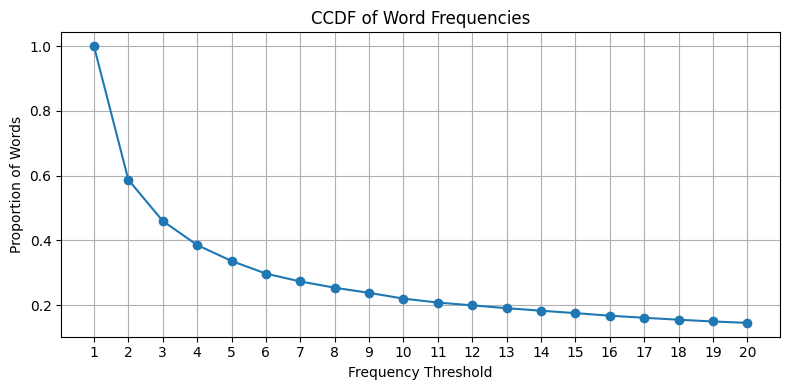

In [ ]:
# Se obtienen las frecuencias de palabras y el número total de palabras.
freqs = Counter(caption_words)
frequencies = list(freqs.values())
total_words = len(frequencies)

# Se calculan los valores de CCDF para cada umbral de frecuencia de 0 a 20.
thresholds = list(range(1, 21))
proportions = [sum(np.array(frequencies) >= threshold) / total_words for threshold in thresholds]

for p, t in zip(proportions, thresholds):
    print(f"Con un umbral de frecuencia de {t}, la proporción de palabras incluidas es {p} o {int(p * 9_628)} palabras.")

# Usamos matplolib para crear la gráfica CCDF.
plt.figure(figsize=(8, 4))
plt.plot(thresholds, proportions, marker='o')
plt.xlabel("Frequency Threshold")
plt.ylabel("Proportion of Words")
plt.title("CCDF of Word Frequencies")
plt.xticks(thresholds)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Definimos nuestro vocabulario usando torchtext, en específico usamos la función `build_vocab_from_iterator`
# Puedes leer más acerca de esta función aquí https://pytorch.org/text/stable/vocab.html#build-vocab-from-iterator.
vocabulary = torchtext.vocab.build_vocab_from_iterator(
    iterator=[caption_words],  # torchtext necesita que el iterados sea de tipo List[List[str]]
    min_freq=5,  # Frecuencia mínima para aceptar una palabra en el corpus
    specials=["<PAD>", "<SOS>", "<EOS>", "<UNK>"],
    special_first=True  # Define que las palabras especiales tomarán los primeros índices del vocabulario.
)
# Valor del índice predeterminado. Este índice se devolverá cuando se consulte un token OOV (Out of Vocabulary).
vocabulary.set_default_index(index=3)

In [ ]:
len(vocabulary), vocabulary["non_existing_word"]

(3004, 3)

## 3.3 Definición del Dataset "Flickr8kDataset" en PyTorch.

Esta sección del cuaderno se centra en la preparación y estructuración del conjunto de datos, para esto, definiremos este como una clase que hereda de `torch.utils.data.Dataset` encargada de regresar una tupla de Tensores representando una imagen y su descripción. De manera específica, la clase será la encargada de:

- Cargar las imágenes y sus descripciones correspondientes.
- Aplicar transformaciones a las imágenes para que estén en un formato adecuado para nuestro modelo.
- Tokenizar las descripciones para convertirlas en secuencias de números enteros que representan palabras.

En esta sección hay partes del código que se han omitido intencionadamente. Tu tarea será completar estas secciones, asegurándote de que el conjunto de datos pueda ser utilizado correctamente por el modelo que entrenaremos más adelante.

In [ ]:
class Flickr8kDataset(torch.utils.data.Dataset):
    """Define the dataset class. The dataset was downloaded from https://www.kaggle.com/datasets/adityajn105/flickr8k"""
    def __init__(self, image_directory: str, image_to_captions_mapping: Dict[str, List[str]], vocabulary, transform=None) -> None:
        self._image_directory = image_directory
        self._image_to_captions_mapping = image_to_captions_mapping
        self._vocabulary = vocabulary
        self._transform = transform

        # TODO: Aplana la estructura de `image_to_captions_mapping`: cada nombre de imagen se repetirá
        # según el número de sus leyendas. Como ayuda se define el tipo de dato de _image_caption_pairs
        # la cual es una lista de tuplas en donde cada tupla contiene el nombre de la imagen y su descripción.
        self._image_caption_pairs: List[Tuple[str, str]] = []

        # Flatten the mapping
        for image_name, captions_list in image_to_captions_mapping.items():
            for caption in captions_list:
                self._image_caption_pairs.append((image_name, caption))

    def __len__(self) -> int:
        # TODO: Regresa el tamaño correcto del conjunto de datos.
        return len(self._image_caption_pairs)

    def __getitem__(self, idx: int):
        image_name, caption = self._image_caption_pairs[idx]
        image_path = os.path.join(self._image_directory, image_name)
        image = Image.open(image_path).convert('RGB')

        # TODO: Aplica las transformaciones a la imagen si estas son proporcionadas.
        if self._transform is not None:
            image = self._transform(image)

        tokenized_caption = [self._vocabulary[word] for word in caption.split(" ")]
        caption = [self._vocabulary["<SOS>"]] + tokenized_caption + [self._vocabulary["<EOS>"]]
        return image, torch.tensor(caption)

In [ ]:
def caption_collate_fn(batch: List[Tuple[torch.Tensor, torch.Tensor]]) -> Tuple[torch.Tensor, torch.Tensor]:
    """Función para agregar padding a las descripciones de imágenes por bache.

    :param batch: Una lista de tuplas donde cada tupla contiene una imagen y su descripción.
    :return: Una tupla que contiene dos tensores:
             1) Un tensor que contiene todas las imágenes del lote, apiladas juntas. Forma: [batch_size, 3, altura, ancho].
             2) Un tensor que contiene todas las descripciones del bache rellenadas con zero para que tengan la misma longitud.
                Forma: [batch_size, longitud_maxima_secuencia].
    """
    images = [item[0] for item in batch]
    captions = [item[1] for item in batch]

    images = torch.stack(images, dim=0)
    # images: [batch_size, 3, height, width]

    # Agregar padding a las secuencias.
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    # Recuerda que el índice del token <PAD> es 0.
    # targets: [batch_size, max_sequence_length]

    for idx, cap in enumerate(captions):
        end = lengths[idx]
        targets[idx, :end] = cap[:end]

    return images, targets

In [ ]:
# Definir transformaciones (para VGG16)
transform = transforms.Compose([
    transforms.Resize((224, 224)),          # 224x224 para imágenes
    transforms.ToTensor(),                  # Convertir PIL Image a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])  # ImageNet normalización
])

# Crear dataset con los parámetros requeridos
dataset = Flickr8kDataset(
    image_directory="/content/drive/MyDrive/GraduateCourseAI/NeuralNetworksSequences/Images",
    image_to_captions_mapping=captions,
    vocabulary=vocabulary,
    transform=transform
)

print(f"Total dataset size: {len(dataset)} image-caption pairs")

# Separar dataset
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print(f"Training size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")

# Crear dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=caption_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=caption_collate_fn)

print("Dataset and DataLoaders created successfully!")

# Test parcial
print("\n=== Testing first batch ===")
for i, (images, captions) in enumerate(train_loader):
    print(f"Images shape: {images.shape}")
    print(f"Captions shape: {captions.shape}")
    print("First batch loaded successfully!")
    break

Total dataset size: 40455 image-caption pairs
Training size: 36409
Test size: 4046
Dataset and DataLoaders created successfully!

=== Testing first batch ===
Images shape: torch.Size([32, 3, 224, 224])
Captions shape: torch.Size([32, 23])
First batch loaded successfully!


# 3.4 División de conjuntos de datos y definición de dataloaders.

En esta sección del cuaderno de realizan dos cosas:
1. Se instancían los conjuntos de entrenamiento y de prueba utilizando la función `torch.utils.data.random_split`.
2. Se define una función para agregar padding a todas las oraciones con el objetivo homologar la lonngitud de estas para poder entrenar el modelo. Esta función será pasada como argumento en el parámerto `collate_fn` de los Dataloaders.

En esta sección no es necesario que completes ningún fragmento de código.

In [ ]:
# Separar dataset
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print(f"Training size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")

Training size: 36409
Test size: 4046


In [ ]:
def caption_collate_fn(batch: List[Tuple[torch.Tensor, torch.Tensor]]) -> Tuple[torch.Tensor, torch.Tensor]:
    """Función para agregar padding a las descripciones de imágenes por bache.

    :param batch: Una lista de tuplas donde cada tupla contiene una imagen y su descripción.
    :return: Una tupla que contiene dos tensores:
             1) Un tensor que contiene todas las imágenes del lote, apiladas juntas. Forma: [batch_size, 3, altura, ancho].
             2) Un tensor que contiene todas las descripciones del bache rellenadas con zero para que tengan la misma longitud.
                Forma: [batch_size, longitud_maxima_secuencia].
    """
    images = [item[0] for item in batch]
    captions = [item[1] for item in batch]

    images = torch.stack(images, dim=0)
    # images: [batch_size, 3, height, width]

    # Agregar padding a las secuencias.
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    # Recuerda que el índice del token <PAD> es 0.
    # targets: [batch_size, max_sequence_length]

    for idx, cap in enumerate(captions):
        end = lengths[idx]
        targets[idx, :end] = cap[:end]

    return images, targets

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=caption_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=caption_collate_fn)

# 4. Entrenamiento y Evaluación del Modelo.

Tras haber definido y preparado nuestro conjunto de datos, es hora de diseñar el corazón del proceso: el entrenamiento y evaluación de nuestro modelo. En esta sección, implementarás los detalles técnicos que permitirán al modelo aprender a generar descripciones a partir de imágenes.

Primero, se establecen varios parámetros esenciales que influirán en la capacidad y eficiencia de nuestro modelo, tales como embed_dim (tamaño de los embeddings), decoder_dim (estado oculto del decodificador), vocab_size (tamaño de nuestro vocabulario), encoder_dim (tamaño de los vectores de anotaciones) y attention_dim (tamaño de los tensores de pesos de las capas lineales del modelo de atención). Estos parámetros determinan la estructura y complejidad de nuestra red neuronal, y su elección adecuada es crucial para el rendimiento del modelo.

A continuación, se instancien tres partes fundamentes para el entrenamiento:
- El modelo a entrenar.
- El optimizador a utlizar para actualizar los pesos.
- La función de pérdida para el cálculo de los gradientes.

Una vez que todo esté en su lugar, diseñarás una función que se encargará de entrenar al modelo. Esta función iterará a través del conjunto de datos, alimentando imágenes al modelo, ajustando sus pesos en función de las predicciones y la realidad, y mejorando paso a paso su capacidad de generar descripciones. Es en esta parte donde tendrás que completar ciertos fragmentos de código.

Finalmente, después de entrenar nuestro modelo, lo guardaremos en disco. Esto nos permitirá reutilizarlo en el futuro sin tener que volver a entrenarlo, y también compartirlo con otros o implementarlo en aplicaciones prácticas.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_dim = 300
decoder_dim = 2048
vocab_size = len(vocabulary)
encoder_dim = 512
attention_dim = 2048

model = SequenceToSequence(embed_dim, decoder_dim, vocab_size, encoder_dim, attention_dim, device, vocabulary).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss(ignore_index=vocabulary["<pad>"])  # Ignoramos el padding al calcular la pérdida.

In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    all_generated_captions = []
    all_true_captions = []

    for i, (images, captions) in enumerate(dataloader):
        # TODO: Mueve las imágenes y las descripciones al dispositivo adecuado (CPU o GPU).
        images, captions = images.to(device), captions.to(device)

        optimizer.zero_grad()

        # TODO: Pasa las imágenes y las descripciones al modelo para obtener las salidas.
        outputs = model(images, captions)

        # Cambiar dimensiones para el cálculo de la función de pérdida.
        outputs = outputs.view(-1, outputs.size(2))
        captions = captions.view(-1)

        # TODO: Calcula la función de pérdida.
        loss = criterion(outputs, captions)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Generar descripciones para evaluar al modelo.
        top1 = outputs.argmax(1)
        generated_captions = [[vocabulary.lookup_token(word.item()) for word in desc] for desc in top1.chunk(batch_size)]
        true_captions = [[vocabulary.lookup_token(word.item()) for word in desc] for desc in captions.chunk(batch_size)]

        if i % 50 == 0:
            print(f"i: {i}, loss: {loss}, true: {true_captions[0]}, generated: {generated_captions[0]}")

    return epoch_loss / len(dataloader)

In [ ]:
# Entrenamiento del modelo.
NUM_EPOCHS = 1
train_losses = []
for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    print(f"Epoch: {epoch + 1}, train loss: {train_loss:.3f}")

In [ ]:
# Guardamos el modelo en disco.
#torch.save(model.cpu().state_dict(), '/content/drive/MyDrive/GraduateCourseAI/NeuralNetworksSequences/seq2seq_model.pth')

# 5. Análisis de Resutados, Generación de Descripciones

¡Felicidades por haber llegado hasta este punto!

Has trabajado en las secciones anteriores y has construido un modelo de descripción de imágenes desde cero. Ahora, en esta sección , vamos a ver cómo se desempeña el modelo en la generación de descripciones para imágenes. Entrenar el modelo puede tomar algo de tiempo; sin embargo, si tienes la oportunidad de hacerlo te lo recomiendo. De esta forma te darás cuenta del desempeño de esto y de que puntos se pueden realizar para mejorarlo. Mientras tanto, te dejo aquí algunos ejemplos de algunas descripciones que generé con un modelo ya entrenado.

## Imagen 1

![2887171449_f54a2b9f39.jpg](attachment:1d467e20-2525-48ce-8833-c2993d79ac4c.jpg)

**Descripción original**: A woman with glasses is sewing.

**Descripción generada**: A man with a a sewing machine

## Imagen 2

![3514179514_cbc3371b92.jpg](attachment:b2e09945-1f00-40b5-abfd-a4d56f94c704.jpg)

**Descripción original**: A baseball player attempts to catch a ball while another runs towards the base.

**Descripción generada**: A baseman player swings to a a base. One. for. base behind.

## Imagen 3

![2981702521_2459f2c1c4.jpg](attachment:e4f738cd-ead6-4d6b-8bb5-91a4cd63c952.jpg)

**Descripción original**: People standing in front of a subway train.

**Descripción generada**: The wait in the of a subway station.

# Imagen 4

![2727051596_be65bfb3d3.jpg](attachment:46b5ed67-9f12-4431-a769-fe93a57939ed.jpg)

**Descripción original**: Two boys enjoy a ride at an amusement park .

**Descripción generada**: Two boys enjoy a ride in lying amusement park. ride

Como puedes ver, el modelo a pesar de tener una idea general sobre lo que está ocurriendo en las imágenes, todavía tiene muchos puntos en los que puede mejorar. Sin embargo, no hay que desanimarnos por esto, hay varios puntos de mejora que puedes considerar para mejorar el rendimiento del modelo:

- Implementar la función de pérdida usada en el artículo "Doubly Stochastic Attention": Esta función de pérdida puede ayudar a mejorar la atención del modelo y, por lo tanto, a generar descripciones más precisas.
- Utilizar más datos de entrenamiento: Como en cualquier modelo de aprendizaje automático, más datos pueden llevar a un mejor rendimiento. Considera ampliar tu conjunto de datos o utilizar técnicas de aumento de datos.
- Utilizar un decodificador de múltiples capas en lugar de una: Un decodificador más complejo puede capturar relaciones más intrincadas en los datos y mejorar la calidad de las descripciones generadas.

Con estos puntos en mente, te recomiendo seguir explorando con el modelo y ver que tan precisas son las descripciones que puedes generar. ¡Buena suerte!